# Physics informed neural networks

In this notebook we will use [Jaxfun](https://github.com/spectralDNS/jaxfun) together with

* [Jax](https://docs.jax.dev/en/latest/index.html)
* [Optax](https://optax.readthedocs.io/en/latest/)
* [Flax](https://github.com/google/flax)

in order to solve a differential equation using the least squares minimization formulation of the problem. We will use basis functions based on regular multi layer perceptrons as well as spectral expansions in orthogonal polynomials.

The ubiquitous linear Helmholtz equation is defined as

$$
u^{''}(x) + \alpha u(x) = f(x), \quad x \in (-1, 1), \, \alpha \in \mathbb{R^+}
$$

and in this notebook it will be used with boundary conditions $u(-1)=u(1)=0$. The function $u(x)$ represents the unknown solution and the right hand side function $f(x)$ is continuous and known. We can define a residual $\mathcal{R}u(x)$ for the Helmholtz equation as

$$
\mathcal{R}u(x) = u^{''}(x) + \alpha u(x) - f(x),
$$

which should be zero for any point in the domain. In this notebook we will approximate $u(x)$ with a neural network $u_{\theta}(x)$, where $\theta \in \mathbb{R}^M$ represents the unknown weights of the network. In order to find $u_{\theta}(x)$ we will attempt to force the residual $\mathcal{R}u_{\theta}(x_i)$ to zero in a least squares sense for some $N$ chosen training points $\{x_i\}_{i=0}^{N-1}$. To this end the least squares problem reads

\begin{equation}
\underset{\theta \in \mathbb{R}^M}{\text{minimize}}\, L(\theta):=\frac{1}{N}\sum_{i=0}^{N-1} \mathcal{R}v(x_i; \theta)^2 + \frac{1}{2} \left(v(-1; \theta)^2+v(1; \theta)^2 \right)
\end{equation}

We start by importing necessary functionality from both [jax](https://docs.jax.dev/en/latest/index.html), [optax](https://optax.readthedocs.io/en/latest/), [flax](https://github.com/google/flax) and Jaxfun. We also make use of Sympy in order to describe the equations.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import sympy as sp
from flax import nnx

from jaxfun.operators import Div, Grad
from jaxfun.pinns.hessoptimizer import hess
from jaxfun.pinns.module import (
    MLP,
    LSQRes,
    NNFunction,
    NNSpace,
    run_optimizer,
    train,
)
from jaxfun.utils.common import lambdify

jax.config.update("jax_enable_x64", True)

Notice the `MLP` class, which is a regular multilayer perceptron subclass of the [flax](https://flax.readthedocs.io/en/latest/) [nnx.Module](https://flax.readthedocs.io/en/latest/nnx_basics.html#the-flax-nnx-module-system) class. 

We start by creating a Jaxfun functionspace for Neural Networks. The created space holds information about the input, output and hidden layers in the NN. Here we create an MLP using one input, 8 neurons for a single hidden layer, and one output:

In [2]:
V = NNSpace(1, 16, 1, name="V")

It is possible to use several hidden layers, for example by choosing `V = NNSpace(1, [8, 8, 8], 1)`.

The MLP function space is subsequently used to create a trial function for the neural network. The function `v` below holds all the unknown weights in the MLP. We initialize the kernel weights using `nnx.initializers.xavier_uniform`

In [3]:
v = NNFunction(V, MLP, rngs=nnx.Rngs(1001), kernel_init=nnx.initializers.xavier_uniform(), name='v')

We will test the solver using a known manufactured solution. We can use any solution, but it should be continuous and the solution needs to use the same symbols as Jaxfun. Below we choose a mixture of a second order polynomial (to get the correct boundary condition) an exponential and a cosine function. This function is continuous, but it requires quite a few unknowns in order to get a decent solution.

In [4]:
x = V.system.x
ue = (1-x**2) * sp.exp(sp.cos(2 * sp.pi * x))

The equation to solve is now described in strong form using the residual $\mathcal{R}u_{\theta}$. Note that we create the right hand side function $f(x)$ from the manufactured solution.

In [5]:
alpha = 1
residual = Div(Grad(v)) + alpha*v - (Div(Grad(ue)) + alpha*ue)

Note that [Div](https://github.com/spectralDNS/jaxfun/blob/main/jaxfun/operators.py) and [Grad](https://github.com/spectralDNS/jaxfun/blob/main/jaxfun/operators.py) are two operators defined in Jaxfun. For a 1D problem on the straight line there is no difference from writing this simply as 

residual = sp.diff(v, x, 2) + alpha * v - (sp.diff(ue, x, 2) + alpha*ue)

We can look at the residual in code:

In [6]:
residual

v(x; V) - ((1 - x**2)*exp(cos(2*x*pi)) + Div(Grad((1 - x**2)*exp(cos(2*x*pi))))) + Div(Grad(v(x; V)))

Note that $\nabla \cdot$ represents divergence and $\nabla v$ represents the gradient of the scalar field $v$. The neural network function $v$ is written as $v(x; V)$ since $v$ is a function of $x$ and it is a basis function on the space $V$. The residual above is in unevaluated form. We can evaluate it using the Sympy function `doit`:

In [7]:
residual.doit()

-8*x*pi*exp(cos(2*x*pi))*sin(2*x*pi) - 4*pi**2*(1 - x**2)*exp(cos(2*x*pi))*sin(2*x*pi)**2 + 4*pi**2*(1 - x**2)*exp(cos(2*x*pi))*cos(2*x*pi) - (1 - x**2)*exp(cos(2*x*pi)) + phi(x) + 2*exp(cos(2*x*pi)) + Derivative(phi(x), (x, 2))

Note that Sympy here evaluates derivatives to the best of its abilities, and the neural network function $v$ has been replaced by the expression $\phi(x)$. This is because "phi" is the default latex symbol used for an `NNFunction`.

We need training points inside the domain in order to solve the least squares problem. Create random points using `jax.random.uniform` and an array `xb` that holds the coordinates of the two boundaries

In [8]:
xj = (jax.random.uniform(jax.random.PRNGKey(2002), 1200) * 2 - 1)[:, None]
xb = jnp.array([[-1.0], [1.0]])

Define the two equations to solve using the `LSQRes` class and a list `eqs`. The items in this list will be added, just like defined for the least squares problem in Eq. (1).

In [9]:
eqs = [LSQRes(residual, xj), LSQRes(v, xb)]
train_step = train(eqs)

To solve the least squares problem we make use of `optax` optimizers. Any optimizers may be used, but we will start with the Adam optimizer, and then switch to a more accurate optimizer after a while. We first run 5000 epochs with Adam

In [10]:
opt = optax.adam(learning_rate=optax.linear_schedule(1e-3, 1e-3, 1000))
opt_adam = nnx.Optimizer(v.module, opt)
run_optimizer(train_step, v.module, opt_adam, 5001, "Adam", 1000)

Epoch 0 Adam, loss: 1241.4307391386674
Epoch 1000 Adam, loss: 26.13524151375604
Epoch 2000 Adam, loss: 2.4940830928929643
Epoch 3000 Adam, loss: 0.4221754759029637
Epoch 4000 Adam, loss: 0.1652112816007701
Epoch 5000 Adam, loss: 0.07104881005702084


The Adam optimizer is good at eliminating local minima and as such it is good at finding a solution that is close to the global minimum. However, Adam is only first order and not able to find a very accurate solution. For this we need either a quasi-Newton or a Newton optimizer. We start with the limited-memory BFGS optimizer and take 10000 more epochs.

In [11]:
optlbfgs = optax.lbfgs(
    memory_size=20,
    linesearch=optax.scale_by_zoom_linesearch(25, max_learning_rate=1.0),
)
opt_lbfgs = nnx.Optimizer(v.module, optlbfgs)
run_optimizer(train_step, v.module, opt_lbfgs, 10001, "LBFGS", 1000)

Epoch 0 LBFGS, loss: 0.07099269925760135
Epoch 1000 LBFGS, loss: 0.0030383101558164797
Epoch 2000 LBFGS, loss: 0.0015011667567430239
Epoch 3000 LBFGS, loss: 0.0007682271263435482
Epoch 4000 LBFGS, loss: 0.0006175901943367421
Epoch 5000 LBFGS, loss: 0.0002661801310727622
Epoch 6000 LBFGS, loss: 0.000178885367778453
Epoch 7000 LBFGS, loss: 0.00014800415429983387
Epoch 8000 LBFGS, loss: 0.0001308430129999962
Epoch 9000 LBFGS, loss: 0.00010155292108491652
Epoch 10000 LBFGS, loss: 9.311057462993854e-05


It is possible to run even more BFGS epoch to further polish this root. However, we will in the end switch to an even more accurate Newton optimizer. Since the Newton optimizer is costly, we run only 101 epochs. The Newton optimizer should only be used when the residual is already close to zero.

In [12]:
opthess = hess(
    use_lstsq=False,
    cg_max_iter=500,
    linesearch=optax.scale_by_zoom_linesearch(25, max_learning_rate=1.0),
)
opt_hess = nnx.Optimizer(v.module, opthess)
run_optimizer(train_step, v.module, opt_hess, 11, "Hess", 1)

Epoch 0 Hess, loss: 9.310620401021122e-05
Epoch 1 Hess, loss: 9.10620686910625e-05
Epoch 2 Hess, loss: 8.983609468753777e-05
Epoch 3 Hess, loss: 8.924313396218961e-05
Epoch 4 Hess, loss: 8.916644391377311e-05
Epoch 5 Hess, loss: 8.790000224447806e-05
Epoch 6 Hess, loss: 8.58128733570263e-05
Epoch 7 Hess, loss: 8.439118850781922e-05
Epoch 8 Hess, loss: 8.194601111756531e-05
Epoch 9 Hess, loss: 8.00481514213832e-05
Epoch 10 Hess, loss: 7.838083204795953e-05


Running even more epochs the solution will become even more accurate.

We can now compute the $L^2$ error norm by comparing to the exact solution

In [13]:
uej = lambdify(x, ue)(xj) # Exact
print(
    "Error", jnp.linalg.norm(v.module(xj) - uej) / jnp.sqrt(len(xj)),
)

Error 0.0005827531491879256


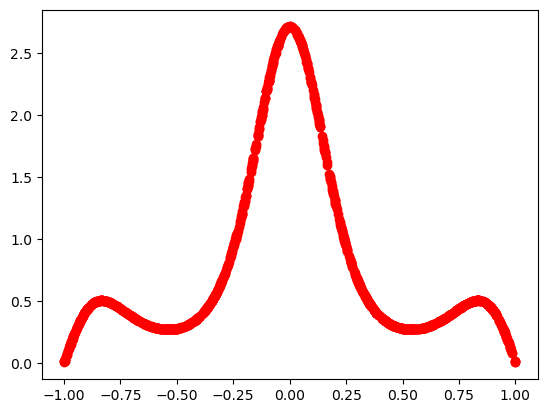

In [14]:
plt.plot(xj, v.module(xj), 'b*', xj, uej, 'ro')

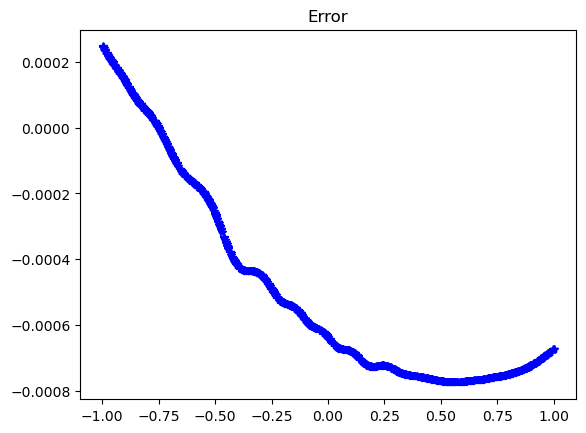

In [15]:
plt.plot(xj, v.module(xj)-uej, 'b*')
plt.title('Error');

In [16]:
gd, st = nnx.split(v.module)
pyt, ret = jax.flatten_util.ravel_pytree(st)

# Spectral least squares solver

The neural network is capturing the solution quite well, but the convergence is quite slow. We know that a problem like the Helmholtz equation with a continuous solution should be very well captured using Legendre or Chebyshev basis functions, that have much better approximation properties than the neural network. Using Jaxfun we can solve this problem with the Galerkin method, but we can also use the least squares formulation similar to as above. The main difference is that we use weak formulations and integrate over the domain. 

The solver below is using simply

$$
u_{\theta}(x) = \sum_{i=0}^{N-1} \hat{u}_i L_i(x)
$$

where $L_i(x)$ is the i'th Legendre polynomial and $\hat{u}_i$ are the unknowns.

The least squares implementation goes as follows:

In [17]:
from jaxfun.Legendre import Legendre
from jaxfun.pinns.module import SpectralModule

VN = Legendre(60)
v = NNFunction(VN, SpectralModule, rngs=nnx.Rngs(1001), kernel_init=nnx.initializers.xavier_uniform(), name='v')
# We can set up the least squares problem as below
#res = Div(Grad(v)) + alpha*v - (Div(Grad(ue)) + alpha*ue)
#eqs = [LSQRes(res, xj), LSQRes(v, xb)]
#train_step = train(eqs)
# But we can also just use the definition from above, since the choice of
# model is made in the optimizer.

opt_adam = nnx.Optimizer(v.module, opt)
run_optimizer(train_step, v.module, opt_adam, 5001, "Adam", 1000)
opt_lbfgs = nnx.Optimizer(v.module, optlbfgs)
run_optimizer(train_step, v.module, opt_lbfgs, 1001, "LBFGS", 100)
opt_hess = nnx.Optimizer(v.module, opthess)
run_optimizer(train_step, v.module, opt_hess, 11, "Hess", 1)

Epoch 0 Adam, loss: 66211069.76438103
Epoch 1000 Adam, loss: 576335.5379735745
Epoch 2000 Adam, loss: 265562.8252874361
Epoch 3000 Adam, loss: 110581.64495475881
Epoch 4000 Adam, loss: 48435.77711605648
Epoch 5000 Adam, loss: 30071.078875504372
Epoch 0 LBFGS, loss: 30061.69973751855
Epoch 100 LBFGS, loss: 15289.120480477179
Epoch 200 LBFGS, loss: 5194.850291042578
Epoch 300 LBFGS, loss: 3454.87001766096
Epoch 400 LBFGS, loss: 1725.2766719876167
Epoch 500 LBFGS, loss: 1290.6713075845498
Epoch 600 LBFGS, loss: 1080.6877146675547
Epoch 700 LBFGS, loss: 955.5734590400248
Epoch 800 LBFGS, loss: 881.7471829780378
Epoch 900 LBFGS, loss: 797.0091947699144
Epoch 1000 LBFGS, loss: 724.988257633826
Epoch 0 Hess, loss: 724.7684279109635
Epoch 1 Hess, loss: 0.01387031112977115
Epoch 2 Hess, loss: 1.0878244657721637e-10
Epoch 3 Hess, loss: 1.0877690342603775e-10


Note that with only 4 Newton iterations the error plunges to zero. Comparing now with the exact solution we get a very accurate $L^2$ error

In [18]:
print(
    "Error", jnp.linalg.norm(v.module(xj) - uej) / jnp.sqrt(len(xj)),
)

Error 8.457823894845964e-08


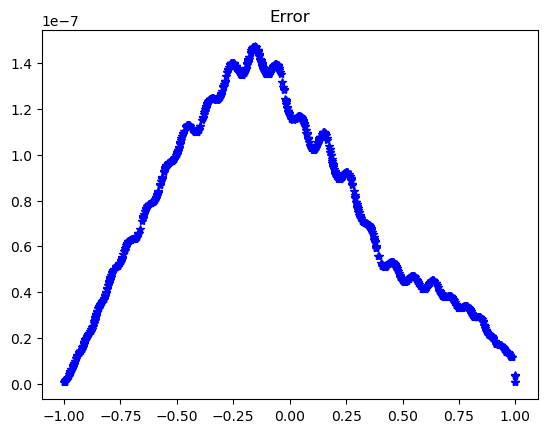

In [19]:
plt.plot(xj, v.module(xj)-uej, 'b*')
plt.title('Error');

# Implicit spectral least squares

In [20]:
from jaxfun import FunctionSpace, TestFunction, TrialFunction, inner

D = FunctionSpace(
    60, Legendre, bcs={"left": {"D": 0}, "right": {"D": 0}}, name="D", fun_str="psi"
)
v = TestFunction(D, name="v")
u = TrialFunction(D, name="u")

A, L = inner(
    #v * (Div(Grad(u)) + alpha * u) - v * (Div(Grad(ue)) + alpha * ue), # Galerkin
    (Div(Grad(v)) + alpha * v) * (Div(Grad(u)) + alpha * u)
    - (Div(Grad(v)) + alpha * v) * (Div(Grad(ue)) + alpha * ue), # LSQ
    sparse=True,
    sparse_tol=1000,
    return_all_items=False,
)

uh = jnp.linalg.solve(A.todense(), L)
uj = D.evaluate(xj, uh)
uej = lambdify(x, ue)(xj)
error = jnp.linalg.norm(uj - uej) / jnp.sqrt(len(xj))
print(error)

2.8732611885768916e-06


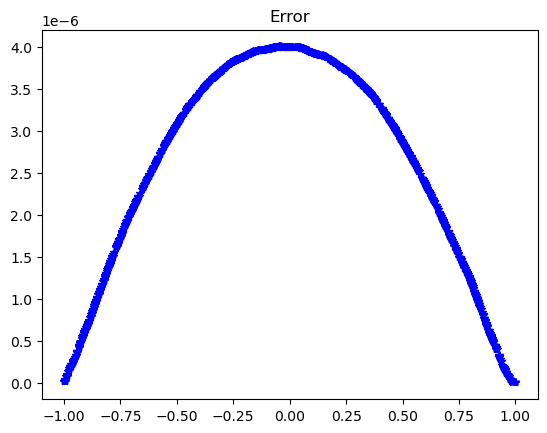

In [21]:
plt.plot(xj, uj-uej, 'b*')
plt.title('Error');

The solution with implicit Galerkin or least squares is actually less accurate than the regular least squares. The main reason for this is the fact that the implicit makes use of only 60 mesh points in order to compute the integration over the domain, whereas the collocation method uses all the 1200 training points. It is possible to improve the accuracy of the implicit integration, but that is not yet implemented in Jaxfun.